In [3]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import random
import os
from ipywidgets import interact, interactive
import ipywidgets.widgets as w
import cv2
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
#from IPython.display import clear_output
from matplotlib import colors
from config import config
import matplotlib.gridspec as gridspec
from IPython.display import display


In [4]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    return fig.colorbar(mappable, cax=cax)


def show3Dimg(image, *imgs):
    n_img = 1 + sum([not img is None for img in imgs])
    def fz(k):
        plt.subplot(1, n_img, 1)
        colorbar(plt.imshow(image[k]))
        
        for i in range(len(imgs)):
            plt.subplot(1, n_img, 2+i)
            colorbar(plt.imshow(imgs[i][k], vmin=0, vmax=30))
        
        plt.show()
    w.interact(fz, k=w.IntSlider(min=0, max=image.shape[0] - 1, step=1, value=0))


def show3Dimg2(image, *masks):
    '''
    Plot contour and mask on original CT image using matplotlib
    image: CT image of dimension 3.
    *masks: usually consists of [mask, contour], then contour 
            would be plot using alpha=1 and mask using alpha 0.5.
    '''
    continuous_update = False
    n_img = 1 + sum([not img is None for img in masks])
    params = {'z': 0, 'level': 128, 'width': 200, 'show_mask': True}
    z_slider = w.IntSlider(min=0, max=image.shape[0] - 1, step=1, value=params['z'], 
                           continuous_update=continuous_update, description="z")
    level_slider = w.IntSlider(min=-1024, max=1000, step=1, value=params['level'], 
                              continuous_update=continuous_update, description="level")
    width_slider = w.IntSlider(min=-1024, max=2000, step=1, value=params['width'], 
                              continuous_update=continuous_update, description="width")
    mask_checkbox = w.Checkbox(value=True, description='show mask', disabled=False)

    def plot_figure():
        z = params['z']
        level = params['level']
        width = params['width']
        show_mask = params['show_mask']
        
        
        plt.imshow(image[z], cmap='gray', vmin=level - width / 2, vmax=level + width / 2)
            

        if show_mask:
            for i in range(len(masks)):
                mask = masks[i].astype(np.float32)
                mask[mask == 0] = np.nan
                plt.imshow(mask[z], cmap=custom_cmap, alpha=0.5 * (i + 1), vmin=1, vmax=28)
                
        plt.axis('off')
        plt.legend(handles=patches1, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0. )
        
        plt.show()
        
        
    def on_z_value_change(change):
        params['z'] = change.new
        plot_figure()
        
    def on_level_value_change(change):
        params['level'] = change.new
        plot_figure()
        
    def on_width_value_change(change):
        params['width'] = change.new
        plot_figure()
        
    def on_mask_value_change(change):
        params['show_mask'] = change.new
        plot_figure()
    
    display(z_slider, level_slider, width_slider, mask_checkbox)
    
    z_slider.observe(on_z_value_change, names='value')
    level_slider.observe(on_level_value_change, names='value')
    width_slider.observe(on_width_value_change, names='value')
    mask_checkbox.observe(on_mask_value_change, names='value')
    
    plot_figure()


def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


def show_image_and_mask(img):
    """
    Given CT img, produce interactive jupyter notebook slider across axial slice
    img: [D,H,W] or [D,H,W,3]
    """

    def fz(k):
        plt.imshow(img[k], vmin=img.min(), vmax=img.max() + 1)
        plt.show()
        
    w.interact(fz, k=w.IntSlider(min=0, max=img.shape[0] - 1, step=1, value=0))
    

def draw_one_rect(img, box, color=(0, 0, 255), scale=3, text=''):
    """
    Given one slice of CT scan, draw one box on that slice with rectangle of size scale times.
    img: [H,W,3]
    box: [y,x,r]
    color: RGB, default (0,128,255)
    scale: how big square box relative to the nodule, default 3
    """
    y0, x0, h, w = box
    H, W, _ = img.shape

    h = h * scale
    w = w * scale
    x0 = max(0, x0 - w / 2)
    y0 = max(0, y0 - h / 2)
    x1, y1 = min(W - 1, x0 + w), min(H - 1, y0 + h)
    h = int(h)
    w = int(w)
    x0, x1, y0, y1 = int(x0), int(x1), int(y0), int(y1)

    cv2.rectangle(img, (x0, y0), (x1, y1), color, 0, lineType=4)

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.2
    thickness = 0
    size = cv2.getTextSize(text, font, font_scale, thickness)[0]
    text_bottom_right = (x1, y1 + size[1])
    cv2.putText(img, text, text_bottom_right, font, font_scale, color, thickness, cv2.LINE_AA)
    return img


def draw_one_bbox(img, box, color, scale, text):
    """
    Given CT scan in numpy with 3 channels, draw one bounded box on each slice within 2x nodule size.
    img: [D,H,W,3]
    box: [z,y,x,r]
    color: RGB
    scale: how big square box relative to the nodule
    """
    D, H, W, _ = img.shape
    z, _, _, d, _, _ = box
    start = max(0, int(z - d / 2))
    end = min(D - 1, int(z + d / 2))
    for z in range(start, end + 1):
        img[z] = draw_one_rect(img[z], box[[1, 2, 4, 5]], color=color, text=text, scale=scale)
    return img


def draw_bboxes(img, bboxes, color=(0, 128, 255), scale=2):
    """
    Given CT scan in numpy, draw bounded boxes on each slice up within 2x nodule size.
    img: [D,H,W] or [D,H,W,3]
    bboxes: [num, 4] or [num, 5] with dimension 0 probability
    color: RGB, default (0,128,255)
    scale: how big square box relative to the nodule, default 2
    """
    assert img.ndim == 3 or img.ndim == 4
    if img.ndim == 3:
        img = np.repeat(img[:, :, :, np.newaxis], 3, axis=3)

    num = int(len(bboxes))
    colors = get_cmap(num)
    for i, box in enumerate(bboxes):
        if len(box) == 6:
            img = draw_one_bbox(img, box, list(colors(i))[:-1], scale, '')
        elif len(box) == 7:
            p = box[0]
            text = '%.2f' % (p)
            img = draw_one_bbox(img, box[1:], list(colors(i))[:-1], scale, text)
        else:
            raise NotImplementedError

    return img


def draw_ground_truth(img, bboxes, color=(255,0,0), scale=3):
    return draw_bboxes(img, bboxes, color=color, scale=scale)


def draw_rpn(img, bboxes, color=(0, 255, 0), scale=3):
    return draw_bboxes(img, bboxes, color=color, scale=scale)


def draw_rcnn(img, bboxes, color=(255, 255, 255)):
    return draw_bboxes(img, bboxes, color=color)


def draw_points(img, points, alpha=0.5):
    """
    Given CT scan in numpy, draw points on the original img
    img: [D,H,W] or [D,H,W,3]
    points: [D, H, W] indicating the class each pixel belongs to
    """
    assert img.ndim == 3 or img.ndim == 4
    if img.ndim == 3:
        img = np.repeat(img[:, :, :, np.newaxis], 3, axis=3)
        
    num = int(points.max())
    colors = get_cmap(num)
    for i in range(1, num + 1):
        img[points == i] = img[points == i] * (1 - alpha) + np.array(list(colors(i))[:-1]) * alpha
        
    return img


def draw_text(img, text, color=(1., 1., 1.)):
    """
    Given img, draw text at the top right of each slice of img
    img: [D, H, W, 4]
    text: str type, the text you want to put
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 0
    size = cv2.getTextSize(text, font, font_scale, thickness)[0]
    text_bottom_right = (0, 5 + size[1])

    for i in range(len(img)):
        cv2.putText(img[i], text, text_bottom_right, font, font_scale, color, thickness, cv2.LINE_AA)

    return img


def draw_gt(img, mask):
    img = img.copy()
    img = draw_points(img, mask)
    img = draw_text(img, 'Ground Truth')

    return img


def draw_pred(img, mask):
    img = img.copy()
    img = draw_points(img, mask)
    img = draw_text(img, 'Prediction')
    
    return img


def generate_image_anim(img, interval=200, save_path=None):
    """
    Given CT img, return an animation across axial slice
    img: [D,H,W] or [D,H,W,3]
    interval: interval between each slice, default 200
    save_path: path to save the animation if not None, default None

    return: matplotlib.animation.Animation
    """
    fig = plt.figure()
    ims = []
    for i in range(len(img)):
        im = plt.imshow(img[i], animated=True)
        ims.append([im])
    anim = animation.ArtistAnimation(fig, ims, interval=interval, blit=True,
                                     repeat_delay=1000)
    if save_path:
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
        anim.save(save_path)

    return anim


def plot_compare_figure(image, gt, pred, params, save_dir, show_all_legend, fmt=['png']):
    interpolation = 'spline36'
    z = params['z']
    level = params['level']
    width = params['width']
    show_mask = params['show_mask']
    
    # Ignore the start and end of z slice
    start = params['start'][1:]
    end = params['end'][1:]

    #         fig, ax = plt.subplots(n_nod, 3)
    nrow = 1
    ncol = 4
    title_font_size = 10
    gs = gridspec.GridSpec(nrow, ncol,
             wspace=0.01, hspace=0.01, 
             top=0.7, bottom=0.3, 
             left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

    #         plt.subplot(gs[0, 0]).set_title('CT Image', size=title_font_size)
    #         plt.subplot(gs[0, 1]).set_title('Ground Truth', size=title_font_size)
    #         plt.subplot(gs[0, 2]).set_title('Model Prediction', size=title_font_size)

    # CT Image
    ax= plt.subplot(gs[0, 0])

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image[z], cmap='gray', vmin=level - width / 2, vmax=level + width / 2, interpolation=interpolation)
    ax.text(0.95, 0.95, 'W: {}, L: {}'.format(width, level),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='white', fontsize=15)

    c1 = start[0]
    c2 = start[1]
    d1 = end[0] - start[0]
    d2 = end[1] - start[1]
    yx_rect = patches.Rectangle((c2, c1),d2,d1,
                         linewidth=1, edgecolor='white', facecolor='none')
    ax.add_patch(yx_rect)
    
    image = image.copy()[:, start[0]:end[0], start[1]:end[1]]
    gt = [g.copy()[:, start[0]:end[0], start[1]:end[1]] for g in gt[0]]
    pred = [p.copy()[:, start[0]:end[0], start[1]:end[1]] for p in pred[0]]

    # Show ground truth on image
    masks = gt
    ax= plt.subplot(gs[0, 1])

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image[z], cmap='gray', vmin=level - width / 2, vmax=level + width / 2, interpolation=interpolation)
    if show_mask:
        for i in range(len(masks)):
            mask = masks[i].astype(np.float32)
            mask[mask == 0] = np.nan
            ax.imshow(mask[z], cmap=custom_cmap, alpha=0.5 * (i + 1), vmin=1, vmax=28)

    # Show prediction on image
    masks = pred
    ax= plt.subplot(gs[0, 2])

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image[z], cmap='gray', vmin=level - width / 2, vmax=level + width / 2, interpolation=interpolation)
    if show_mask:
        for i in range(len(masks)):
            mask = masks[i].astype(np.float32)
            mask[mask == 0] = np.nan
            ax.imshow(mask[z], cmap=custom_cmap, alpha=0.5 * (i + 1), vmin=1, vmax=28)


    # Show gt and prediction comparison
    ax= plt.subplot(gs[0, 3])

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image[z], cmap='gray', vmin=level - width / 2, vmax=level + width / 2, interpolation=interpolation)

    gt_ctr = gt[1].copy()
    gt_ctr[gt_ctr > 0] = 1
    # Make value for pred_ctr to 2, correponding to the color_map2
    pred_ctr = pred[1].copy()
    pred_ctr[pred_ctr > 0] = 2

    if show_mask:
        gt_ctr = gt_ctr.astype(np.float32)
        gt_ctr[gt_ctr == 0] = np.nan
        pred_ctr = pred_ctr.astype(np.float32)
        pred_ctr[pred_ctr == 0] = np.nan
        ax.imshow(gt_ctr[z], cmap=custom_cmap2, alpha=1, vmin=1, vmax=2)
        ax.imshow(pred_ctr[z], cmap=custom_cmap2, alpha=1, vmin=1, vmax=2)



    #         plt.axis('off')
    legend_properties = {'size': 20} # {'weight': 'bold'}
    if show_all_legend:
        first_legend = plt.legend(handles=patches1, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop=legend_properties)
    else:
        g = np.unique(gt[0][z])
        p = np.unique(pred[0][z])
        a = set(g).union(p)
        a.remove(0)
        a = list(a)
        p = [patches1[i - 1] for i in a]
        first_legend = plt.legend(handles=p, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop=legend_properties)

    ax = plt.gca().add_artist(first_legend)
    plt.legend(handles=patches2,  bbox_to_anchor=(1.01, 0.2), loc=2, borderaxespad=0., prop=legend_properties)
    
    if 'png' in fmt:
        plt.savefig(os.path.join(save_dir, '{}.png'.format(z)), bbox_inches='tight')
    if 'pdf' in fmt:
        plt.savefig(os.path.join(save_dir, '{}.pdf'.format(z)), bbox_inches='tight')

In [5]:
def show3D_comparison(image, gt, pred, bbox, save_dir='paper_figs/', show_all_legend=True):
    '''
    show 3d comparison plot of ground truth and prediction. 
    Four views: original CT image with zoomed in bbox, ground truth overlay on the image, 
                         prediction overlay on the image, gt and pred contour outline comparison

    image: CT image of dimension 3
    gt: a list of 2 elements, the first is ground truth mask and the second is ground truth contour
    pred: a list of 2 elements, the first is predicted mask and the second is predicted contour
    bbox: [start, end], plot zoomed in region (defined by this param) for view 2 - 4
    '''
    continuous_update = False
#     n_img = 1 + sum([not img is None for img in masks])
    start, end = bbox
    print(start, end)
    params = {'z': 0, 'level': 128, 'width': 200, 'show_mask': True, 'start': start, 'end': end}
    z_slider = w.IntSlider(min=0, max=image.shape[0] - 1, step=1, value=params['z'], 
                           continuous_update=continuous_update, description="z")
    level_slider = w.IntSlider(min=-1024, max=1000, step=1, value=params['level'], 
                              continuous_update=continuous_update, description="level")
    width_slider = w.IntSlider(min=-1024, max=2000, step=1, value=params['width'], 
                              continuous_update=continuous_update, description="width")
    mask_checkbox = w.Checkbox(value=True, description='show mask', disabled=False)
    
    N = 3
    plt.rcParams['legend.markerscale'] = 0.2
    fig, axes = plt.subplots(1, N)
    plt.subplots_adjust(hspace=0)
    for i in range(N):
        axes[i].set_axis_off()
        
    def on_z_value_change(change):
        params['z'] = change.new
        plot_compare_figure(image, gt, pred, params, save_dir, show_all_legend)
        
    def on_level_value_change(change):
        params['level'] = change.new
        plot_compare_figure(image, gt, pred, params, save_dir, show_all_legend)
        
    def on_width_value_change(change):
        params['width'] = change.new
        plot_compare_figure(image, gt, pred, params, save_dir, show_all_legend)
        
    def on_mask_value_change(change):
        params['show_mask'] = change.new
        plot_compare_figure(image, gt, pred, params, save_dir, show_all_legend)
    
    display(z_slider, level_slider, width_slider, mask_checkbox)
    
    z_slider.observe(on_z_value_change, names='value')
    level_slider.observe(on_level_value_change, names='value')
    width_slider.observe(on_width_value_change, names='value')
    mask_checkbox.observe(on_mask_value_change, names='value')
    
    plot_compare_figure(image, gt, pred, params, save_dir, show_all_legend)

In [6]:
# color for Nodule in the config['roi_names]
color_dict = {
    1: {'color': [128, 0, 128], 'name': 'Nodule'},
}


# color for the contour outline in the comparison subplot
color_dict2 = {
    1: {'color': [0, 0, 255], 'name': 'Ground Truth'},
    2: {'color': [255, 255, 0], 'name': 'Model'},
}

# Initialize color maps 
# color map for Nodule
N = len(config['roi_names'])
cmaplist = [list(np.array(color_dict[i]['color']) / 255.) for i in range(1, N + 1)]
custom_cmap = colors.ListedColormap(cmaplist)

# color map for model prediction and ground truth comparison
N = 2
legend_names = [color_dict2[i]['name'] for i in range(1, N + 1)]
cmaplist2 = [list(np.array(color_dict2[i]['color']) / 255.) for i in range(1, N + 1)]
custom_cmap2 = colors.ListedColormap(cmaplist2)

# Create legend
# Create legend
patches1 = [patches.Patch(color=cmaplist[i], label="{}".format(config['roi_names'][i])) for i in range(len(cmaplist))]
patches2 = [patches.Patch(color=cmaplist2[i], label="{}".format(legend_names[i]), fill=False) for i in range(len(cmaplist2))]

In [37]:
from config import config
data_dir = 'F:/Cengiz/NoduleNet/workspace/data/LIDC/preprocessed_test/3/'
data_dir = config['preprocessed_data_dir']
test_set_name = config['test_set_name']
from dataset.mask_reader import MaskReader
dataset = MaskReader(data_dir, test_set_name, config, mode='eval')

In [38]:
_,truth_bboxes,truth_labels,truth_masks,masks,original_image = dataset[0]
pred_mask_dir = 'F:/Cengiz/NoduleNet/results/cross_val_test/res/200/1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860.npy'
pred_mask = np.load(pred_mask_dir)

In [39]:
gt = [truth_masks,truth_bboxes]
print(truth_bboxes.shape,truth_masks.shape,original_image.shape, pred_mask.shape,masks.shape)

(2, 6) (2, 336, 240, 320) (326, 231, 318) (336, 240, 320) (1, 336, 240, 320)


In [40]:
print(truth_bboxes)

[[128.5 100.5  23.5  16.   16.   16. ]
 [200.5  63.5 255.   12.   14.   15. ]]


In [66]:
from utils.util import masks2bboxes_masks_one, pad2factor
pred_bbox, pred_mask_new = masks2bboxes_masks_one(pred_mask, border=config['bbox_border'])
pred_mask_new = np.array(pred_mask_new).astype(np.uint8)

In [42]:
print(pred_mask_new[0:2].shape)
pred_mask_new = pred_mask_new[0:2]

(2, 336, 240, 320)


In [67]:
pred_bbox = pred_bbox[0:9]
print(pred_bbox)

[[129.0, 100.0, 23.0, 15, 15, 15, 1], [200.5, 63.5, 255.5, 12, 14, 14, 1], [304.5, 166.0, 232.5, 14, 13, 14, 1], [109.5, 121.0, 19.5, 12, 15, 14, 1], [202.0, 62.0, 254.0, 13, 11, 11, 1], [177.0, 190.0, 52.0, 13, 19, 15, 1], [226.0, 118.0, 260.5, 13, 13, 14, 1], [148.5, 57.0, 36.5, 12, 15, 14, 1], [168.0, 53.0, 115.0, 13, 19, 17, 1]]


In [44]:
pred_ = [pred_mask_new, pred_bbox]


[0, 0, 0] [326, 231, 318]


IntSlider(value=0, continuous_update=False, description='z', max=325)

IntSlider(value=128, continuous_update=False, description='level', max=1000, min=-1024)

IntSlider(value=200, continuous_update=False, description='width', max=2000, min=-1024)

Checkbox(value=True, description='show mask')

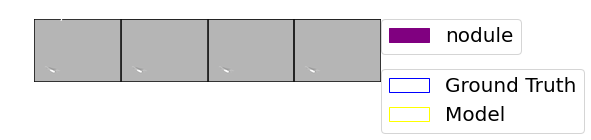

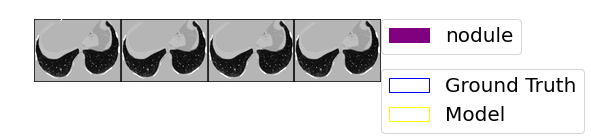

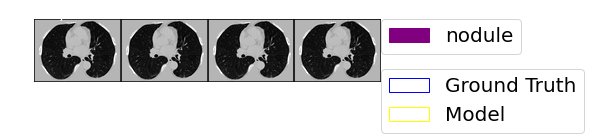

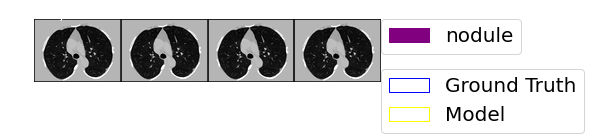

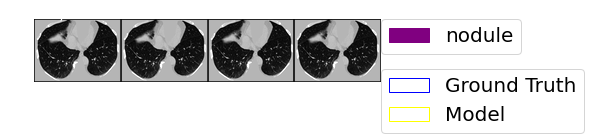

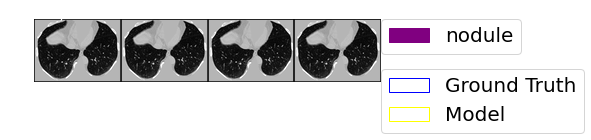

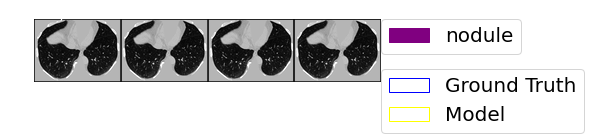

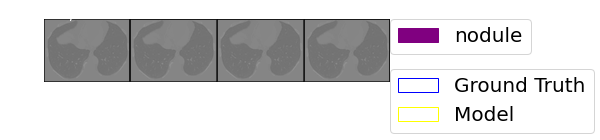

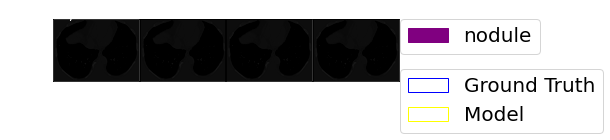

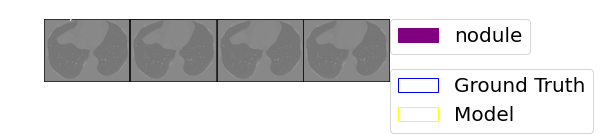

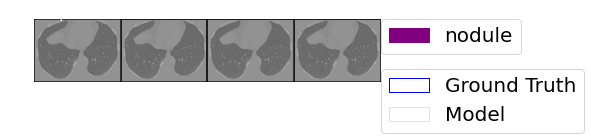

In [19]:
show3D_comparison(original_image, gt, pred_, bbox=([0,0,0], [326, 231, 318]), save_dir='paper_figs/', show_all_legend=True)

IntSlider(value=0, continuous_update=False, description='z', max=325)

IntSlider(value=128, continuous_update=False, description='level', max=1000, min=-1024)

IntSlider(value=200, continuous_update=False, description='width', max=2000, min=-1024)

Checkbox(value=True, description='show mask')

TypeError: Invalid shape (6,) for image data

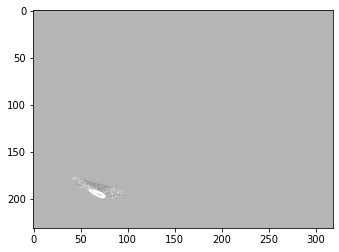

In [18]:
show3Dimg2(original_image,gt[1])

In [ ]:
def plot_compare_figure(image, gt, pred, save_dir,z, show_all_legend, fmt=['png']):
    interpolation = 'spline36'
    level = params['level']
    width = params['width']
    show_mask = params['show_mask']
    
    # Ignore the start and end of z slice
    start = params['start'][1:]
    end = params['end'][1:]

    #         fig, ax = plt.subplots(n_nod, 3)
    nrow = 1
    ncol = 4
    title_font_size = 10
    gs = gridspec.GridSpec(nrow, ncol,
             wspace=0.01, hspace=0.01, 
             top=0.7, bottom=0.3, 
             left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

    #         plt.subplot(gs[0, 0]).set_title('CT Image', size=title_font_size)
    #         plt.subplot(gs[0, 1]).set_title('Ground Truth', size=title_font_size)
    #         plt.subplot(gs[0, 2]).set_title('Model Prediction', size=title_font_size)

    # CT Image
    ax= plt.subplot(gs[0, 0])

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image[z], cmap='gray', vmin=level - width / 2, vmax=level + width / 2, interpolation=interpolation)
    ax.text(0.95, 0.95, 'W: {}, L: {}'.format(width, level),
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='white', fontsize=15)

    c1 = start[0]
    c2 = start[1]
    d1 = end[0] - start[0]
    d2 = end[1] - start[1]
    yx_rect = patches.Rectangle((c2, c1),d2,d1,
                         linewidth=1, edgecolor='white', facecolor='none')
    ax.add_patch(yx_rect)
    
    image = image.copy()[:, start[0]:end[0], start[1]:end[1]]
    gt = [g.copy()[:, start[0]:end[0], start[1]:end[1]] for g in gt[0]]
    pred = [p.copy()[:, start[0]:end[0], start[1]:end[1]] for p in pred[0]]

    # Show ground truth on image
    masks = gt
    ax= plt.subplot(gs[0, 1])

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image[z], cmap='gray', vmin=level - width / 2, vmax=level + width / 2, interpolation=interpolation)
    if show_mask:
        for i in range(len(masks)):
            mask = masks[i].astype(np.float32)
            mask[mask == 0] = np.nan
            ax.imshow(mask[z], cmap=custom_cmap, alpha=0.5 * (i + 1), vmin=1, vmax=28)

    # Show prediction on image
    masks = pred
    ax= plt.subplot(gs[0, 2])

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image[z], cmap='gray', vmin=level - width / 2, vmax=level + width / 2, interpolation=interpolation)
    if show_mask:
        for i in range(len(masks)):
            mask = masks[i].astype(np.float32)
            mask[mask == 0] = np.nan
            ax.imshow(mask[z], cmap=custom_cmap, alpha=0.5 * (i + 1), vmin=1, vmax=28)


    # Show gt and prediction comparison
    ax= plt.subplot(gs[0, 3])

    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(image[z], cmap='gray', vmin=level - width / 2, vmax=level + width / 2, interpolation=interpolation)

    gt_ctr = gt[1].copy()
    gt_ctr[gt_ctr > 0] = 1
    # Make value for pred_ctr to 2, correponding to the color_map2
    pred_ctr = pred[1].copy()
    pred_ctr[pred_ctr > 0] = 2

    if show_mask:
        gt_ctr = gt_ctr.astype(np.float32)
        gt_ctr[gt_ctr == 0] = np.nan
        pred_ctr = pred_ctr.astype(np.float32)
        pred_ctr[pred_ctr == 0] = np.nan
        ax.imshow(gt_ctr[z], cmap=custom_cmap2, alpha=1, vmin=1, vmax=2)
        ax.imshow(pred_ctr[z], cmap=custom_cmap2, alpha=1, vmin=1, vmax=2)



    #         plt.axis('off')
    legend_properties = {'size': 20} # {'weight': 'bold'}
    if show_all_legend:
        first_legend = plt.legend(handles=patches1, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop=legend_properties)
    else:
        g = np.unique(gt[0][z])
        p = np.unique(pred[0][z])
        a = set(g).union(p)
        a.remove(0)
        a = list(a)
        p = [patches1[i - 1] for i in a]
        first_legend = plt.legend(handles=p, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop=legend_properties)

    ax = plt.gca().add_artist(first_legend)
    plt.legend(handles=patches2,  bbox_to_anchor=(1.01, 0.2), loc=2, borderaxespad=0., prop=legend_properties)
    
    if 'png' in fmt:
        plt.savefig(os.path.join(save_dir, '{}.png'.format(z)), bbox_inches='tight')
    if 'pdf' in fmt:
        plt.savefig(os.path.join(save_dir, '{}.pdf'.format(z)), bbox_inches='tight')

In [ ]:
plt.imshow(original_image[128],cmap='gray')
#gt = gt[0]
pred = pred_[0]
masks = gt[0]
print(pred_[0].shape, original_image.shape)
for i in range(len(masks)):
    #print(np.where(mask == 1))
    #print(mask.shape)
    mask = masks[i].astype(np.float32)
    mask[mask == 0] = np.nan
    pred_one = pred[i].astype(np.float32)
    pred_one[pred_one == 0] = np.nan
    for k in range(127,original_image.shape[0]):
        plt.imshow(original_image[k],cmap='gray')
        plt.imshow(mask[k], cmap=custom_cmap, alpha=0.15, vmin=1, vmax=28)
        plt.imshow(pred_one[k], cmap=custom_cmap2, alpha=0, vmin=.1, vmax=2)
        plt.savefig('paper_figs/' + str(k)+'.png',dpi=600)
        #ax.imshow(pred_ctr[z], cmap=custom_cmap2, alpha=1, vmin=1, vmax=2)
#for i in range     masks = pred


(2, 336, 240, 320) (326, 231, 318)


In [88]:
mask =masks[0]
print(mask[128].shape, original_image[128].shape[0],original_image[128].shape[1])
mask = mask[128,0:original_image[128].shape[0],0:original_image[128].shape[1]]
print(mask.shape,original_image[128].shape)
cimage=cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
dst = cv2.addWeighted(original_image[128], 0.7, cimage, 1, 0.0)
cv2.imshow('dst',dst)
cv2.waitKey(0)

(240, 320) 231 318
(231, 318) (231, 318)


error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-2b5g8ysb\opencv\modules\core\src\arithm.cpp:669: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'cv::arithm_op'


In [78]:
tmp = original_image.resize(masks[0].shape)
image = image.copy()[:, start[0]:end[0], start[1]:end[1]]
    gt = 
    pred = [p.copy()[:, start[0]:end[0], start[1]:end[1]] for p in pred[0]]


IndentationError: unexpected indent (<ipython-input-78-2761cb3f6c64>, line 3)

In [ ]:
for i 